# <center>NLP for sentiment analysis of tweets: demo for using the most popular libraries


<center>
In this notebook I will use three of the most popular libraries for <strong>sentiment analysis</strong> on text data.<br/><br/>
It's not any text data, though. I'll be using a dataset of tweets, collected for a period of three weeks around the <a href="https://www.kaggle.com/manchunhui/us-election-2020-tweets/code">2020 US presidential elections</a>.<br/><br/>
I downloaded the dataset directly from the link above, but if you want to tackle another topic, you can open a <a href="https://developer.twitter.com/en/apply-for-access">Twitter developer account</a> and start collecting your own tweets using <a href="https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/introduction">Tweet lookup</a> or <a href="https://github.com/JustAnotherArchivist/snscrape">snscrape</a>.<br/><br/>
I start with some classic exploratory data analysis (to answer questions like how many tweets we have or what is the date range ?), I proceed to text pre-processing (text data has a lot of extra material like stop words and many words are not in the most useful form (e.g. plurals will be converted to singular etc), then I do sentiment analysis using three libraries (TextBlob, VADEDR and Flair) and compare the results to see which is the most suited for our dataset.<br/><br/>
And because I am using data related to a political campaign, I want to see what actionable insights we can draw based on the sentiment analysis results. After all, the purpose of any Data Science analysis is to find out how to solve a problem. In this case, I'm part of the campaign management for one of the candidates and we use Twitter sentiment analysis to see how to increase our voter base. #This is a hypothetical problem; I am not actually involved in Politics and hope to never be.<br/><br/>

## Table of contents

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Text pre-processing](#2.-Text-pre-processing)
3. [Intro to sentiment analysis](#3.-Intro-to-sentiment-analysis)
4. [Sentiment analysis with TextBlob](#4.-Sentiment-analysis-with-TextBlob)
5. [Sentiment analysis with VADER](#5.-Sentiment-analysis-with-VADER)
6. [Sentiment analysis with Flair](#6.-Sentiment-analysis-with-Flair)
7. [Which is the best sentiment analysis library ?](#7.-Which-is-the-best-sentiment-analysis-library-?)
8. [Actionable insights from sentiment analysis of tweets](#8.-Actionable-insights-from-sentiment-analysis-of-tweets)

## 1. Exploratory Data Analysis

This section will contain both data exploration as well as some data wrangling. As we explore, we realize there are things we need to remove, add, change.   

Our data is separates into two csv files. 

In [ ]:
import numpy as np # numerical computation
import pandas as pd # # data processing/manipulation
import matplotlib.pyplot as plt # basic data visualization
import seaborn as sns # nicer data visualization
import time

# stopwords, tokenizer, stemmer
import nltk  
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

import re # regular expressions

!pip install gensim
import gensim
from gensim.parsing.preprocessing import remove_stopwords # we also use gensim for stopwords removal

from textblob import TextBlob

!pip install flair
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single

In [ ]:
from pathlib import Path

out_folder = '../output' # folder to save intermediary data to
Path(out_folder).mkdir(parents=True, exist_ok=True)

In [ ]:
# Loading each dataset
trump_df = pd.read_csv('../input/us-election-2020-tweets/hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('../input/us-election-2020-tweets/hashtag_joebiden.csv', lineterminator='\n')

In [ ]:
print('Total number of records in Trump dataset: ', trump_df.shape)
print('Total number of records in Biden dataset: ', biden_df.shape)

trump_initial_count = trump_df.shape[0]
biden_initial_count = biden_df.shape[0]

Each dataset has 21 columns (21 features).  
And we have ~970k tweets in the Trump dataset and ~776k for Biden.

In [ ]:
trump_df.columns

Our dataset has the following columns (I have higlighted what I think is relevant for our sentiment analysis):

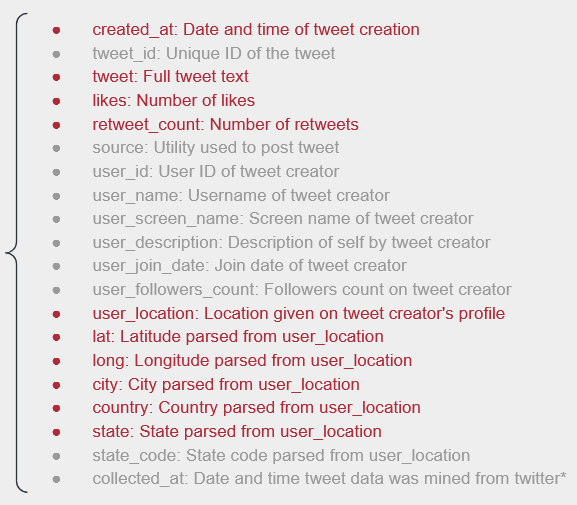

In [ ]:
# Remove unneeded columns
irrelevant_columns = ['source','user_name','user_screen_name','user_description','user_join_date','collected_at']

#a more conservative way of considering which columns are not relevant
#irrelevant_columns = ['collected_at']
trump_df = trump_df.drop(columns=irrelevant_columns)
biden_df = biden_df.drop(columns=irrelevant_columns)

# Renaming columns
#trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
#                                    "state": "State", "user_followers_count": "Followers"})
#biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
#                                    "state": "State", "user_followers_count": "Followers"})

# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

### 1.1 Localization

I'm interested in the Countries our users are tweeting from. I only want to keep USA data for this analysis, because my public of interest are those who will actually vote in the USA 2020 presidential elections. I can't know for sure which ones of these tweet authors are USA registered voters, but removing tweets outside the US seems like a good enough heuristic. 

In [ ]:
biden_df.country.unique()

Keep only tweets from USA.

In [ ]:
trump_usa_df = trump_df[trump_df.country == "United States of America"]
biden_usa_df = biden_df[biden_df.country == "United States of America"]

del trump_df
del biden_df

In [ ]:
print('Total number of records in Trump USA dataset: ', trump_usa_df.shape)
print('Total number of records in Biden USA dataset: ', biden_usa_df.shape)

### 1.2 Duplicate tweets

I already know (from how the dataset was collected) that the split into two datasets was made on the criterion: tweets mentioning Trump went into Trump file and tweets mentioning Biden went into the Biden csv file.  

But how about tweets mentioning both of them ? I'll check if the two datasets have any tweets in common. 

In [ ]:
tids = trump_usa_df.tweet_id
bids = biden_usa_df.tweet_id

ids_tweets_in_common = set(trump_usa_df.tweet_id).intersection(set(biden_usa_df.tweet_id))
len(ids_tweets_in_common)

Around 20.000 tweets show up in both dataset. I think it doesn't make sense for the same tweet to contribute to compute the sentiment towards Biden and towards Trump. Let's say one tweet has a negative emotion, do we know if it's negative towards both candidates or only towards one of them and just mentions the second ?  
Let's have a look at a few of the 'duplicate' tweets.

In [ ]:
pd.options.display.max_colwidth = 1000 #by default, Python will likely display only the first 50 characters from a long text

biden_usa_df.tweet.loc[biden_usa_df.tweet_id.isin(list(ids_tweets_in_common))].head(5)

From the tweets above, it looks like the duplicate tweets are not really helpful for a per candidate sentiment analysis, so I'll drop them.  

In [ ]:
trump_usa_unique_df = trump_usa_df[~trump_usa_df['tweet_id'].isin(ids_tweets_in_common)]
biden_usa_unique_df = biden_usa_df[~biden_usa_df['tweet_id'].isin(ids_tweets_in_common)]

In [ ]:
print('Total number of unique records in Trump USA dataset: ', trump_usa_unique_df.shape)
print('Total number of unique records in Biden USA dataset: ', biden_usa_unique_df.shape)

In [ ]:
del trump_usa_df
del biden_usa_df

### 1.3 Language


And the second observation is that we have Tweets in Neglish and Spanish too. Most Natural Language Processing libraries can only handle a single language. So we will keep only the tweets in English.  

I tried several of the packages that can handle language detection which are mentioned in this <a href="https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language">Stackoverflow thread</a>.  

TextBlob unfortunately cannot handle this many requests (for each of our tweets), because it uses Google Translate API and the number of successive calls is limited in time. 

<a href="https://chardet.readthedocs.io/en/latest/usage.html">chardet</a> only works for Cyrillic alphabet and some other exotic languages, but not for English or Spanish.  

Installing <a href="https://github.com/bsolomon1124/pycld3">pyCLD3</a> on a Windows machine (my personal laptop where I developed this Notebook) was a nightmare with no happy ending. 

In [ ]:
example_tweet = '#Wisconsin podría ser el punto de inflexión en la carrera entre #Trump y #Biden https://t.co/WFf8A1hAn7'

In [ ]:
#try out TextBlob on a sample tweet
'''from textblob import TextBlob
b = TextBlob(example_tweet)
print(f'Language of text: \n{example_tweet}\nis: {b.detect_language()}')
'''

Chardet won't recognize French or Spanish, for example.

In [ ]:
import chardet
print(chardet.detect("Я люблю вкусные пампушки".encode('cp1251')))
print(chardet.detect("Et le français? Pouvons-nous obtenir une identification correcte?".encode('cp850')))
print(chardet.detect("¡Qué pena! pero todo el mundo ama el español, ¿verdad?".encode('utf-8')))

But langdetect seems to do a good job.

In [ ]:
#try out langdetect on a sample tweet
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
detect("#Wisconsin podría ser el punto de inflexión en la carrera entre #Trump y #Biden https://t.co/WFf8A1hAn7")

In [ ]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def get_language(tweet):
    try:                                                          
        lang=detect(tweet)                                      
    except:                                                       
        lang='no'
        # for some tweets, detect will throw an error.
        # uncomment the line below if you want to look further into this behavior
        #print("This tweet throws an error:", tweet)  
    return lang

From my initial tests with TextBlob I saw that language detection will take a long time. Let's first try it on 1.000 records to get an idea of how long we'll have to wait for our full datasets language analysis.

In [ ]:
import time

start_time = time.time()

test_df = trump_usa_unique_df.iloc[:1000].copy()
test_df['lang'] = test_df.tweet.apply(lambda x: get_language(x))

stop_time = time.time()

print(f'It took {np.around((time.time() - start_time),decimals=1)} seconds')

Multiply the result above with 100 and we have a rough estimation of how long we'll have to wait per dataset. 

In [ ]:
import time
start_time = time.time()

trump_usa_unique_df['lang'] = trump_usa_unique_df.tweet.apply(lambda x: get_language(x))

stop_time = time.time()
print(f'It took {np.around((time.time() - start_time), decimals=1)} seconds')

In [ ]:
start_time = time.time()

biden_usa_unique_df['lang'] = biden_usa_unique_df.tweet.apply(lambda x: get_language(x))

stop_time = time.time()
print(f'It took {np.around((time.time() - start_time), decimals=1)} seconds')

In [ ]:
# language detection may take 20-30 minutes, depending on your device
# better run this cell to save the data, in case you walk away from your computer
# and the Notebook enter sleep mode
#biden_usa_unique_df.to_csv(out_folder + '/biden_usa_unique_df.csv', index=False)
#trump_usa_unique_df.to_csv(out_folder + '/trump_usa_unique_df.csv', index=False)

In [ ]:
# if you used the cell above to save to file the intermediary results
# uncomment the lines below in case you need to load from file now
#biden_usa_unique_df = pd.read_csv(out_folder + '/biden_usa_unique_df.csv', lineterminator='\r')
#trump_usa_unique_df = pd.read_csv(out_folder + '/trump_usa_unique_df.csv', lineterminator='\r')

Check out our language results.

In [ ]:
biden_usa_unique_df.columns

In [ ]:
plt.figure(figsize=(20,5))
ax = biden_usa_unique_df.lang.value_counts().plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of languages in Biden tweets')
plt.show()

plt.figure(figsize=(20,5))
ax = trump_usa_unique_df.lang.value_counts().plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of languages in Trump tweets')
plt.show()

We keep only the tweets in English.  
First, I'm getting rid of the long names, as they're making it more difficult to follow along, rather than helping, now that they became quite long.

In [ ]:
biden_df = biden_usa_unique_df.copy()
del biden_usa_unique_df

trump_df = trump_usa_unique_df.copy()
del trump_usa_unique_df

In [ ]:
biden_df = biden_df[biden_df.lang == 'en']
trump_df = trump_df[trump_df.lang == 'en']

And now lets see how many tweets we're left with.

In [ ]:
print('Total number of records in Trump dataset: ', trump_df.shape)
print('Total number of records in Biden dataset: ', biden_df.shape)

In [ ]:
print(f'We retained {np.around(trump_df.shape[0]*100/trump_initial_count, decimals=1)}% of the initial Trump dataset')
print(f'And {np.around(biden_df.shape[0]*100/biden_initial_count, decimals=1)}% from Biden')

### 1.4 Date analysis

When were these tweets created ?

In [ ]:
trump_df['ds'] = 'trump'
biden_df['ds'] = 'biden'

# Combine the filtered on United States Trump and Biden Datasets 
tweets_df = pd.concat([biden_df, trump_df],ignore_index=True)

# covnert date to something we can work with easily
tweets_df['created_at'] =  pd.to_datetime(tweets_df['created_at'])

In the frequency distribution of tweets per day below we see an expected pattern. There was more activity on the 23rd of October, when the last debate between the two candidates took place. And then the activity increases again after Nov 3rd, the election day.

In [ ]:
start_time = time.time()

plt.figure(figsize=(15,5))

tweets_df.created_at.dt.date.value_counts().sort_index().plot.bar(rot=90, alpha=0.3,color='green')

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.title('Frequency of tweets per day')
plt.show()

stop_time = time.time()
print(f'It took {(time.time() - start_time)} seconds')

### 1.5 Tweets popularity analysis

In [ ]:
most_popular_tweet = tweets_df.loc[tweets_df['retweet_count'].idxmax()]
print(f" The tweet:\n'{most_popular_tweet.tweet}'\nwas retweeted the most ({most_popular_tweet.retweet_count} times).")

So, our most popular tweet contains irony. I'm curious to see how sentiment analysis libraries will perform on this.

In [ ]:
tweets_df[['tweet_id','user_id','created_at', 'likes', 'retweet_count', 'tweet', 'ds']].iloc[tweets_df.retweet_count.sort_values(ascending=False).head(5).index]

In [ ]:
print(f'Our 2nd most popular tweet was retweeted for number of times equal to {np.around(13500*100/tweets_df.shape[0], decimals=1)}% of our dataset size')

In [ ]:
tweets_df[tweets_df.tweet.str.contains('Are you there')][['created_at', 'tweet', 'user_id']]

Interestingly, our dataset does not contain the retweets. If we would have had 10% of our dataset consisting of the same tweet retweeted by various people, we would be looking further into this phenomenon to decide if we should include all of them. But since it's not the case, we proceed to next step.  

Let's see a distribution of retweets.

In [ ]:
print(f'There are {tweets_df.retweet_count.nunique()} different amounts of retweets')

In the kdeplot below we explore the retweeting behavior. It looks like a huge amount of tweets are never retweeted. And then we have a tiny number of tweets that get retweeted all the way up to ~ 17.500 times. This was to be expected.

In [ ]:
sns.kdeplot(x='retweet_count', data=tweets_df)

### 1.6 "Vocal minority" and "silent majority" effect

Mustafaraj et al. 2011 \[1] showed evidence of the existance on social media of a minority of users which are very vocal, while there is a majority of users which hardly produce content.

We explore this phenomenon in our dataset by looking at the distribution of the number of tweets per user.  
The frequency distribution we obtain confirms that there are a small number of users producing a large portion of the tweets for both candidates (the trend is stronger for Biden).  
This indicates that:    
- drawing conclusions about which candidate is preferred based on the number of tweets would be influenced strongly by this small number of very active users.  

In the section dedicated to 'predicting' election results from Tweets, we will see how we can enforce a policy of 'one vote per person' when analysing tweets.  

**\[1]** Eni Mustafaraj, Samantha Finn, Carolyn Whitlock, and Panagiotis Takis Metaxas. **Vocal minority versus silent majority: Discovering the opionions
of the long tail.** In SocialCom/PASSAT, pages 103–110, 2011.

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,6))

ax.set_title('Frequency distribution of number of tweets per user', fontsize = 16)
sns.kdeplot(trump_df.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump', ax = ax)
sns.kdeplot(biden_df.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden', ax = ax)
labels= ["Trump", "Biden"]
ax.legend(labels)
#ax.set_ylim(0, .005)
plt.show()

## 2. Text pre-processing

Before we begin to use the text of the tweets, we need to perform some **transformations on the text**.  
Let's examine a few tweets to see why.

In [ ]:
#pd.options.display.max_colwidth = 1000
tweets_df.tweet.head(5)

First, we clean our data:
- we convert everything to lowercase
- we remove punctuation, links, @mentions and # hashtags
- we remove stop words - stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”. These don't add any meaningful information for our analysis
- lemmatization - reduces inflected words to the root of that word (e.g. 'pursuing' becomes 'pursue')
- tokenization - split each tweet into a list of individual words

For lemmatization, different libraries give slightly different results.

For an extensive comparison, see this article: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/.  

The clean_text function below can use either nltk or spacy, depending on the argument it receives. 

I have used both and extracted a few tweets for a comparison, shown in the next image. I highlighted in blue the correct form of the words and in red the wrong ones.  
![Lemmatization with spacey and nltk](https://mihaelagrigore.info/wp-content/uploads/2021/03/lemmatization.jpg)

It looks like there's no clear winner between nltk or spacey. You can see in the image above that each of them makes mistakes.

You can use clean_text function to do an analysis yourself.

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text(tweet, lemmatize = 'nltk'):
    """
    Inputs:
    tweet - a string representing the text we need to clean
    lemmatize - one of two possible values {spacy, nltk} 
      two lemmatization methods
      with our dataset, we got the best results with nltk
      but Spacy also did a good job, hence you might 
      try both and compare results for your own data
    
    Output: 
    tokenized - the cleaned text, tokenized (a list of string words)
    """

    tweet = tweet.lower() # lowercase
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE) # remove urls
    tweet = re.sub(r'\@\w+|\#','', tweet) # remove mentions of other usernames and the hashtag character
    tweet = remove_stopwords(tweet) # remove stopwords with Gensim

    if (lemmatize == 'spacy'):
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(tweet)
        tokenized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    elif (lemmatize == 'nltk'): 
        '''
        lemmatization works best when WordNetLemmatizer receives both the text and the part of speech of each word
        the code below assigns POS (part of speech) tag on a per word basis (it does not infer POS from contenxt / sentence), which might not be optimal
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
    
    # remove left over stop words with nltk
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # remove non-alpha characters and keep the words of length >2 only
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]

    return tokenized

def combine_tokens(tokenized): 
    non_tokenized = ' '.join([w for w in tokenized])
    return non_tokenized

Cleaning our tweets.

In [ ]:
start =  time.time()

tweets_df['tokenized_tweet_nltk'] = tweets_df['tweet'].apply(lambda x: clean_text(x, 'nltk'))
tweets_df['clean_tweet_nltk'] = tweets_df['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))

stop = time.time()
print(f'Cleaning all tweets takes ~{round((stop-start)/60, 3)} minutes: ')

My Notebook went into sleep mode quite a few times so now I'm into the habbit of saving data that takes a while to compute, just in case. 

In [ ]:
tweets_df.to_csv(out_folder + '/clean_tweets_df.csv', index=False)

In [ ]:
tweets_df[tweets_df.tweet_id.isin(list(trump_df.tweet_id))].ds = 'trump'
tweets_df[tweets_df.tweet_id.isin(list(biden_df.tweet_id))].ds = 'biden'

Let's have a look at what some tweets look like after 'cleaning'. 

In [ ]:
tweets_df.head(10)[['tweet', 'clean_tweet_nltk']]

## 3. Intro to sentiment analysis

Sentiment analysis means computing in some way the overall valence of the text. Valence usually means whether a text is negative, neutral or positive.

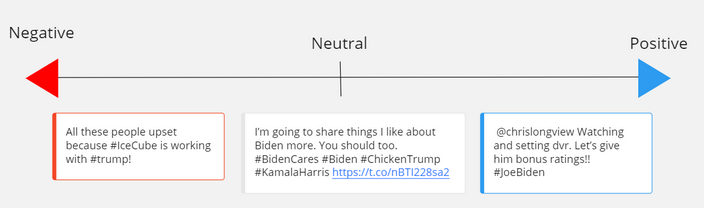


Different libraries / algorithms assess text valence in different ways, but this would be the gist of the sentiment analysis.

The most popular algorithms are:
- **Rule-based models**  
    For example, TextBlob and Vader
    They use a bag-of-words approach: the text is considered to be the sum of its constituent words, 
- **Word-embedding-based models:**  
    Words are represented as vectors of numbers in an n-dimensional space
    This mapping from individual words to a continuous vector space can be generated through various methods: neural networks, dimensionality reduction, co-occurence matrix.

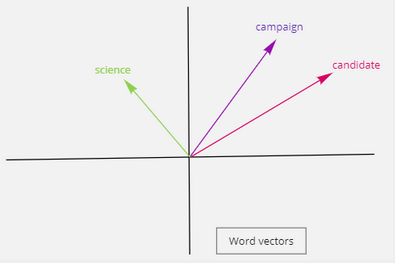

### Popular libraries for sentiment analysis
For this analysis of tweets I tried three of the currently most popular sentiment analysis libraries.  
**TextBlob** and **Vader** use rule-based models, while **Flair** uses word embeddings.

All three output a **continuous** number between -1 and 1.  
If one needs a classification into **categories** instead of these numerical values, the common interpretation is that <0 is negative, 0 is neutral and >0 is positive. The cutoff points for the three categories are not set in stone and can be adapted based on the results / visual inspection.

Let’s discuss the differences now: 
1. **<a href='https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis'>TextBlob</a>**
    is the simplest of them
    It does estimate though how factual versus opinionated a text is
2. **<a href='https://github.com/cjhutto/vaderSentiment'>Vader</a>**
    The valence for the words in the dictionary was empirically validated by multiple human judges “especially attuned to microblog-like contexts”  
    Uses some heuristics to recognize word negations (“cool” versus “not cool”) and word intensifiers (“a bit sad” versus “really sad”)  
    Cannot recognize typos and will consider them out of vocabulary words (veri relevant for twitter, where users tend to not spell correctly)
3. **<a href='https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md'>Flair</a>** is a pre-trained character-level LSTM (recurrent neural networks) classifier which takes into account:  
    the sequence of words  
    the sequence of letters -> recognizes typos  
    intensifiers ('so', 'very', ‘a bit’ etc)   
    Flair is trained on IMDB movie reviews dataset and retraining is resource intensive.  
    Very polarizing (assigns very positive or very negative scores), but not much in the middle


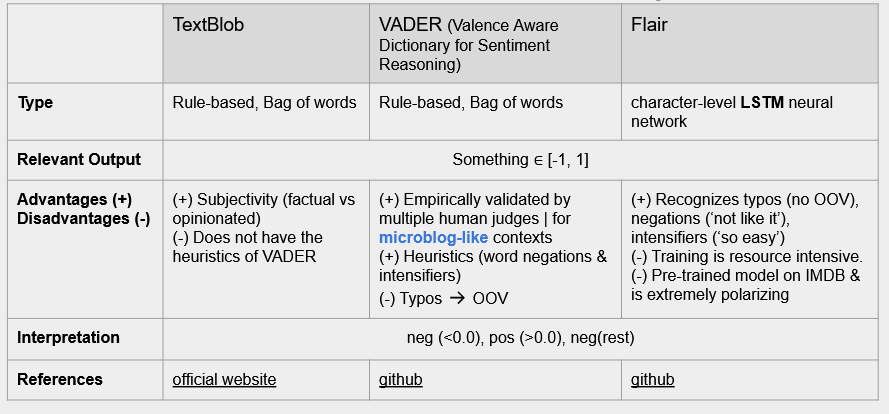

## 4. Sentiment analysis with TextBlob

According to [TextBlob's official website](https://textblob.readthedocs.io/en/dev/), TextBlob "provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more."

TextBlob library will output something like this for each snippet of text that it analyzes:  
_Sentiment(polarity=-0.125, subjectivity=0.5916666666666667)_

That is, TextBlob will output:
- a measure of polarity, which can have values in the interval \[-1, 1\]
- an estimation of subjectivity, ranging is \[0.0, 1.0\] where 0.0 is very objective (dealing with facts) and 1.0 is very subjective (opinions). 

Interpreting the results:  
- TextBlob documentation does not give precise guidelines for interpreting the numberic output ([see TextBlob ReadTheDocs section for Sentiment analysis here](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis))
- We will adopt the approach we encountered in this [KDNuggets post](https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html):  
  - we will label <0 values as 'negative' 
  - 0 values as 'neutral' 
  - and \>0 values as 'positive'

Function for labelling tweets based on classification criteria described above.

In [ ]:
# Helper Function to assign Label for Sentiment Analysis with TextBlob
def create_sentiment_labels(df, feature,value):
    '''
    in: 
        dataframe 
        value on which to classify
        feature - column name of the feature that receives the label
    out: 
        does not return a value
        modifies the dataframe received as parameter
    '''

    df.loc[df[value] > 0,feature] = 'positive'
    df.loc[df[value] == 0,feature] = 'neutral'
    df.loc[df[value] < 0,feature] = 'negative'

In [ ]:
# Polarity and subjectivity
def sentiment_analysis(dataframe):
    dataframe['blob_polarity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['blob_subjectivity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    create_sentiment_labels(dataframe, 'blob_sentiment','blob_polarity')
    
    return dataframe[['clean_tweet_nltk','blob_polarity','blob_subjectivity','blob_sentiment']].head()   

In [ ]:
import time
start =  time.time()

sentiment_analysis(tweets_df)

stop = time.time()
print(f'Sentiment analysis with TextBlob took: {round((stop-start)/60, 3)} minutes')

In [ ]:
tweets_df.head(10)[['blob_polarity','blob_subjectivity', 'blob_sentiment']]

### 4.1 Different ways to look at the same data.  

#### Option a

In the next plot, we will compute an average polarity per candidate as follows:  
- we simply average the polarity feature computed by TextBlob across all tweets per candidate. 

Issues with this approach:  
- imagine we have 1 user who tweeted 99 times, each having polarity -1 (a candidate opposer). And 1 user who tweeted once with polarity 1 (a candidate supporter). If we average across all tweets, we obtain **-0.98**.  

What can we infer from this result ? 
- inferring support / opposing for the candidate would be wrong, since in our sample we actually have one opposant and 1 supporter.
- we can only infer the trivial: that the result is just the average sentiment across all tweets.

In [ ]:
#update the divided dataset
trump_df = tweets_df[tweets_df.ds=='trump']
biden_df = tweets_df[tweets_df.ds=='biden']

fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob analysis: nmean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0) per candidate (one tweet, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [biden_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_tweet =trump_df['blob_polarity'].mean()
trump_usa_subj_tweet = trump_df['blob_subjectivity'].mean()
biden_usa_pol_tweet = biden_df['blob_polarity'].mean()
biden_usa_subj_tweet = biden_df['blob_subjectivity'].mean()

#### Option b  

Another option is to:
- first average sentiment expressed through tweets per user id -> we will have one averge expressed sentiment per user per candidate
- then average across the whole population for each candidate

In [ ]:
# the below gives us a mean per user
# trump_usa_df[['user_id', 'Polarity']].groupby(['user_id'])['Polarity'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('TextBlob analysis: mean polarity (-1.0, 1.0) and mean subjectivity (0.0, 1.0)\nper candidate (one user, one sentiment)', fontsize=14)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2,)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 12)

values = [biden_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2,)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 12)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

trump_usa_pol_user = trump_df.groupby(['user_id'])['blob_polarity'].mean().mean()
trump_usa_subj_user = trump_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()
biden_usa_pol_user = biden_df.groupby(['user_id'])['blob_polarity'].mean().mean()
biden_usa_subj_user = biden_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()

### Let's see how our results are influenced by choosing either of the two options mentioned above


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

fig.suptitle('TextBlob analysis: \nmean polarity and mean subjectivity\n (tweet level = one tweet, one sentiment) vs (user level = one user, one sentiment)', fontsize=16)

#features = ['Polarity', 'Subjectivity']
features = np.array([1, 2])
values_tweet = [ trump_usa_pol_tweet, trump_usa_subj_tweet]
values_user = [ trump_usa_pol_user, trump_usa_subj_user]

#values = [[trump_usa_pol_tweet, trump_usa_subj_tweet], 
#[trump_usa_pol_user, trump_usa_subj_user]]

axes[0].bar(features-0.2, values_tweet, width=0.2, align = 'center', color = 'y')
axes[0].bar(features, values_user, width=0.2, align = 'center', color = 'g')
#axes[0].bar(features,values)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Average value', fontsize = 14)
axes[0].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])
labels= ["tweet level", "user level"]
axes[0].legend(labels)

values_tweet = [ biden_usa_pol_tweet, biden_usa_subj_tweet]
values_user = [ biden_usa_pol_user, biden_usa_subj_user]
axes[1].bar(features-0.2,values_tweet, width=0.2, align = 'center', color = 'y')
axes[1].bar(features,values_user, width=0.2, align = 'center', color = 'g')
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Average value', fontsize = 14)
axes[1].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])

labels= ["tweet level", "user level"]
axes[1].legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

It doesn't really matter how we average the sentiment. In any case, "one user one sentiment" makes much more sense for our analysis. But it's easier to code the "one tweet one sentiment", so we'll use this one, since it has the same result.

In [ ]:
plt.figure(figsize=(6,5))

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])
trump = (trump_df['blob_sentiment'].sort_values().value_counts()/trump_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = (biden_df['blob_sentiment'].sort_values().value_counts()/biden_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']]
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

Observations from the above plot:
- the ratio of positive:negative is higher for Biden than for Trump. When people tweet about Biden, they tend to be less negative than when they tweet about Trump.

In [ ]:
plt.figure(figsize=(6,5))

ax = plt.gca()
ax.set_title('--Absolute--\nTextBlob sentiment analysis - \nabsolute frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])
trump = (trump_df['blob_sentiment'].sort_values().value_counts())[['negative', 'neutral', 'positive']]
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha=0.6)

biden = (biden_df['blob_sentiment'].sort_values().value_counts())[['negative', 'neutral', 'positive']]
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha = 0.6)

#ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Absolute frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

The absolute frequency plot is relevant because all those negative tweets could potentially be support votes for the other candidate, since in presidential elections people only have 2 options. If they hate one candidate, that could be enough reason to vote for the other one. 

## 5. Sentiment analysis with VADER

VADER (Valence Aware Dictionary for Sentiment Reasoning) was developed in 2014.   
You can check [Vader's official github](https://github.com/cjhutto/vaderSentiment) for details of how the tool was designed and how to use it. 

According to [VADER's github](https://github.com/cjhutto/vaderSentiment), VADER is "Empirically validated by multiple independent human judges, VADER incorporates a "gold-standard" sentiment lexicon that is especially attuned to microblog-like contexts."

Vader is a pre-trained model. If you want to read about the model in detail, the official website recommends [2]


Vader **outputs** something like this:   
_{'neg': 0.0, 'neu': 0.436, 'pos': 0.564, 'compound': 0.3802}_

**Negative**, **neutral** and **positive** are scores between 0 and 1.  
The **compound** value reflects the overall sentiment of the text. It's computed based on the values of negative, neutral and positive. It ranges from -1 (maximum negativity) to 1 (maximum positivity). 

The is no standard way to interpret compound. 
One can decide that whatever is larger than 0 is positive and lower is negative, while 0 means neutral.    
But we can also decide to look only at more extreme values, like above or below +/- 0.8, for example.   
It really depends on the kind of data you have.

**\[2]** Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analysis_vader(df, clean = True):
    if clean:
        target_col = 'clean_tweet_nltk'
        prefix = 'vader_clean_'
    else:
        target_col = 'tweet'
        prefix = 'vader_'
    
    scores_col = prefix+'scores'
    
    #let's make it vader_sentiment, so that it has the same naming convention as TextBlob and Flair sentiment score
    #compound_col = prefix+'compound'
    compound_col = prefix+'polarity'
    
    #comp_score_col = prefix+'comp_score'
    comp_score_col = prefix+'sentiment' 
    
    df[scores_col] = df[target_col].apply(lambda tweet: sid.polarity_scores(tweet))
    df[compound_col] = df[scores_col].apply(lambda d: d['compound'])
    create_sentiment_labels(df,comp_score_col,compound_col)

In [ ]:
start = time.time()

sentiment_analysis_vader(tweets_df)
sentiment_analysis_vader(tweets_df, clean = False)

stop = time.time()
print(f'Sentiment analysis with VADER took: {round((stop-start)/60, 3)} minutes')

#update the divided dataset
trump_df = tweets_df[tweets_df.ds=='trump']
biden_df = tweets_df[tweets_df.ds=='biden']

Does it matter if we clean the tweets before feeding them to Vader ? Does Vader itself perform a good enough cleaning ?
We answer this question by classifying tweets into positive / neutral / negative using both approaches and then looking at the accuracy_score for the labels obtained through the two methods.

In [ ]:
from sklearn.metrics import accuracy_score

start = time.time()

print(f"Accuracy score for our cleaning vs vader tweet cleaning for Trump: {accuracy_score(trump_df['vader_sentiment'],trump_df['vader_clean_sentiment']):.4}")
print(f"Accuracy score for our cleaning vs vader tweet cleaning for Biden: {accuracy_score(biden_df['vader_sentiment'],biden_df['vader_clean_sentiment']):.4}")

stop = time.time()
print(f'This took: {round((stop-start)/60, 3)} minutes')

It looks like there is 84% consensus for Trump and 88% consensus for Biden for sentiment per tweet when VADER is fed the raw data versus the cleaned data.  
So that means the decision to feed raw or cleaned data should be given some thought.  
Since we don't have labelled data, the only way to decide which method is best is by visual inspection. 

In [ ]:
#Uncomment the code below if you want to visualize some tweets yourself
#We decided based on analysis to feed the raw tweet to VADER and let it run the cleaning itself

#Some tweets arel long. This setting makes sure Python does not truncate the output. Default value is 50.
'''
pd.options.display.max_colwidth = 300
trump_df[['tweet', 'clean_tweet_nltk', 'vader_sentiment', 'vader_clean_sentiment']].head(20)
'''

Let's have a look at number of tweets per valence for both candidates and see if we spot anything interesting. 

In [ ]:
def get_valence_relative_freq(df):
    #grouped = df.sort_values('comp_score').groupby(['comp_score'], sort=False)
    grouped = df.sort_values('vader_sentiment').groupby(['vader_sentiment'], sort=False)
    valence = grouped['vader_sentiment'].value_counts(normalize=False, sort=False)
    valence = valence.droplevel(0)
    valence = valence / valence.sum()
    return valence

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

trump_tmp = get_valence_relative_freq(trump_df)
biden_tmp = get_valence_relative_freq(biden_df)

#plt.figure(figsize=(8,6))
fig, axes = plt.subplots(1, 2, figsize=(8,5))
fig.suptitle('Vader sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
#fig.tight_layout()

#sns.barplot(trump_tmp.index, trump_tmp.values, ax=axes[0])
(trump_tmp).plot(kind='bar', ax = axes[0])
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)
axes[0].set_ylim(0, .5)

#ax2 = sns.countplot(x="comp_score", data=biden_tmp)
#sns.barplot(biden_tmp.index, biden_tmp.values,  ax=axes[1])
(biden_tmp).plot(kind='bar', ax = axes[1])
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)
axes[1].set_ylim(0, .5)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,5))
sns.set_style("white")

ax = plt.gca()
ax.set_title('--Relative--\nTextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)

features = np.array([1,2,3])

trump = get_valence_relative_freq(trump_df)
ax.bar(features-0.3, trump.values, width=0.3, align = 'center', color = 'r', alpha= .6)

biden = get_valence_relative_freq(biden_df)
ax.bar(features, biden.values, width=0.3, align = 'center', color = 'b', alpha= .6)

ax.set_ylim(0, .5)
ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('Relative frequency', fontsize = 14)

ax.set_xticklabels(['', '', 'Negative', '', 'Neutral', '', 'Positive'])

labels= ["Trump", "Biden"]
ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

### Some observations we can make based on plot above:
- within-candidates: Trump has a ratio of 1:1 for positive to negative tweets, while for Biden, it's almost 2:1
- between-candidates: 
    - higher % of positive tweets for Biden
    - higher % of negative tweets for Trump

## Average sentiment score per candidate

In [ ]:
print(trump_df['vader_polarity'].mean())
print(biden_df['vader_polarity'].mean())

fig = plt.figure(figsize=(5,5))

fig.suptitle('Mean VADER compund score (between -1.0 and 1.0)\nfor Trump and Biden', fontsize=16)

features = ['Mean Valence Trump', 'Mean Valence Biden']
values = [trump_df['vader_polarity'].mean(), biden_df['vader_polarity'].mean()]

plt.bar(features,values, width=0.2)

axes = plt.gca()
axes.set_ylim(-.3, .3)
axes.set_xlabel('Feature', fontsize = 14)
axes.set_ylabel('Value', fontsize = 14)

plt.show()

Let's explore further the differences between sentiment for the two candidates.  
We continue with visual inspection of the distribution of sentiment scores.

In [ ]:
bins = 50

fig = plt.figure(figsize=(8,5))
fig.suptitle('Histograms of tweets polarity per candidate (VADER)', fontsize=16)

plt.hist(trump_df['vader_polarity'], bins = bins, alpha = 0.5, color = 'r')
plt.hist(biden_df['vader_polarity'], bins = bins, alpha = 0.5, color = 'b')

axes = plt.gca()
axes.set_ylim(0, 4000)

labels= ["Trump", "Biden"]
axes.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.88])
plt.show()

## 6. Sentiment analysis with Flair

Flair is a pre-trained character-level LSTM (recurrent neural networks) classifier which takes into account:
- the sequence of words
- the sequence of letters 
- intensifiers ('so', 'very' etc)
Advantage over VADER: by looking at character level, it can recognize and correct for typos (e.g. it will recognize that 'anoy' means 'annoy'), which for VADER would just be an OOV (Out Of Vocabulary) word (and thus ignored).

Advantage over VADER: by looking at character level, it can recognize and correct for typos (e.g. it will recognize that 'anoy' means 'annoy'), which for VADER would just be an OOV (Out Of Vocabulary) word (and thus ignored).

### Pre-trained Flair models
As we lack computing power, we will use a freely available pre-trained Flair model.  

For sentiment classification, Flair offers two pre-trained models (as mentioned in one of the [official Flair tutorials on their github here](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md)):

<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	table.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid black;
	}
	table.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>

<table class="tableizer-table" style="border: 1px solid #CCC;">
<thead><tr class="tableizer-firstrow"><th>ID</th><th>Language</th><th>Task</th><th>Training Dataset</th><th>Accuracy</th></tr></thead><tbody>
 <tr><td>sentiment'</td><td>English</td><td>detecting positive and negative sentiment (transformer-based)</td><td>movie and product reviews</td><td>98.87</td></tr>
 <tr><td>sentiment-fast'</td><td>English</td><td>detecting positive and negative sentiment (RNN-based)</td><td>movie and product reviews</td><td>96.83</td></tr>
</tbody></table>

The pre-trained classifier of Flair was trained on **IMDB reviews database** . We don't know how well this may generalize to our tweets data.

In [ ]:
classifier = TextClassifier.load('en-sentiment')

Remember when we removed from our dataset tweets in other languges than English ? If we had kept them, our 'en' classifier declared above wouldn't have been able to interpret them anyway. 

Here's an example of how to use Flair classifier to predict for one sentence. Flair clasifier outputs the assigned label and a value between 0 and 1 indicating the confidence level for this prediction.

In [ ]:
sentence = Sentence('The food was not horrible!')
classifier.predict(sentence)

print('Sentence above is: ', sentence.labels)

Helper functions for performing the sentiment analysis using Flair

In [ ]:
def flair_make_sentences(text):
    """ Break apart text into a list of sentences """
    sentences = [sent for sent in split_single(text)]
    return sentences

def flair_predict_sentences(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    # stacked_embeddings.embed(text)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['labels'][0]['confidence']
    else:
        result = -(text.to_dict()['labels'][0]['confidence'])
    return round(result, 3)

def flair_get_scores_per_sentences(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(flair_predict_sentences(sentences[i]))
    results.append(flair_predict_sentences(sentences[0]))
    return results

def flair_get_sum(scores):
    result = round(sum(scores), 3)
    return result

def flair_get_avg_from_sentences(scores):
    result = round(np.mean(scores), 3)
    return result

def flair_get_score_tweet(text):
  if not text:
    return 0
  s = Sentence(text)
  classifier.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    result = s.to_dict()['labels'][0]['confidence']
  else:
    result = -(s.to_dict()['labels'][0]['confidence'])
  return round(result, 3)

def sentiment_analysis_flair(polarity):
  if polarity > 0:
    return 'positive'
  if polarity == 0:
    return 'neutral'
  if polarity < 0:
    return 'positive'

Let's explore the Flair results in the context of a comparison between all three methods (TextBlob, VADER and Flair).

## 7. Which is the best sentiment analysis library ?

Let's compare the following:

1. TextBlob
2. VADER
3. Flair per sentence
4. Flair per tweet

Our dataset is not labelled, so there is no way for us to compare predictions to some 'ground truth'.  
We will, instead, compare each algorithm's predictions to the ones from the other two.  

## Flair: predict sentiment per sentence versus sentiment per tweet

But first we will explore and compare sentiment labelling for two ways to use Flair and here is why.  
We asked oursleved what is the best way to perform prediction for Tweet ?   
- option 1: Should we predict on the whole Tweet ?  
- option 2: Should we split into sentences, predict for each sentence and then make an average ?

As we did not find clear indications for this in the official [Flair documentation](https://github.com/flairNLP/flair), we will explore both methods. 

In [ ]:
records = 1000
temp = tweets_df[tweets_df.ds=='trump'][:records].copy()

import time
start = time.time()

#flair sentiment by diving tweet into sentenes and averaging
temp['sentences'] = temp['clean_tweet_nltk'].apply(flair_make_sentences)
temp['scores'] = temp['sentences'].apply(flair_get_scores_per_sentences)
temp['flair_scores_avg'] = temp.scores.apply(flair_get_avg_from_sentences)

#flair sentiment on the whole tweet
temp['flair_one_score'] = temp['clean_tweet_nltk'].apply(flair_get_score_tweet)

stop = time.time()
print(round((stop-start)/60, 3))

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(6,5))

plt.title('Flair polarity: per sentence versus per tweet')
ax = plt.gca()

ax.hist(temp['flair_scores_avg'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')

ax.set_ylim(0, 100)
labels= ["Flair sentences", "Flair tweet"]
ax.legend(labels)
plt.show()

The above plot shows that the two methods for computing polarity of a tweet with Flair produce exactly the same results. It might sound silly, but worth trying out because this level of details are not easily accessible from the documentation.

## Comparison of the three sentiment analysis libraries

We only perform this analysis on the 1000 data points because Flair is very resource intensive. But try it out on the whole dataset if you have more computing power.

In [ ]:
bins = 50
alpha = 0.6
fig = plt.plot(figsize=(8,7))

plt.title('Distribution of sentiment scores\nTextBlob vs VADER vs Flair', fontsize=16)

ax = plt.gca()

ax.hist(temp['blob_polarity'], bins = bins, alpha = alpha, color = 'r')
ax.hist(temp['vader_polarity'], bins = bins, alpha = alpha, color = '#ffd343')
ax.hist(temp['flair_one_score'], bins = bins, alpha = alpha, color = 'g')
ax.set_ylim(0, 100)
labels= ["TextBlob", "VADER", "Flair"]
ax.legend(labels)

ax.set_ylabel('Frequency', fontsize = 14)

#fig.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

## Observations from the distribution plot of sentiment produced by TextBlob, VADER and Flair

We notice that TextBlob and VADER tend to:  
- classify a lot of the data as neutral
- VADER has a bimodal distribution, while TextBlob is unimodal. 

Flair:  
- has no predilection for neutral. 
- and it's extremly polarizing, compared to TextBlob or VADER

Regarding the lack of a strong neutral category in Flair (compare it to TextBlob and VADER for example), [Flair co-creator, Alan Akbik,](https://youtu.be/5Hg18QxU6mA?t=2481) explains that when Flair sentiment analysis model was trained on reviews dataset and there was too much variability in people's attitudes in the middle, which prevented the model from learning something useful for a rating that translates to 'average'.
Some people would give an average rating if the product/service had a few shortcomings, while others would punish with an average rating if it was a complete disapointment.  
According to Alan Akbik, they ended up training only on more extreme reviews, to avoid the middle reviews with very low signal to noise ration.  
That was the best approach for movie reviews. But we don't know if it's the best for our data too, for tweets.

### Agreement between TextBlob, VADER and Flair predictions

We know the three differ in how extreme their predicted sentiment value is. But do they agree on the direction of that sentiment, regardless of whether they agree on intensity. That is, if TexBlob predicts a weak sentiment and Flair a strong sentiment, are they both negative or both positive ? Or one predicts a -.2 (weak negative) and the other a .9 (strong positive) ?

To answer the question above, tet's see the percentage of times these algorithms agree with one another when classifying the sentiment of a tweet.

In [ ]:
temp['flair_sentiment'] = temp['flair_one_score'].apply(sentiment_analysis_flair)

In [ ]:
print(f"Consensus TextBlob - VADER: {accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']):.4}")
print(f"Consensus TextBlob - Flair: {accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']):.4}")
print(f"Consensus VADER - Flair: {accuracy_score(temp['vader_sentiment'],temp['flair_sentiment']):.4}")

In [ ]:
fig = plt.figure(figsize=(6,6))

ax = plt.gca()
ax.set_title('Agreement between TextBlob, VADER and Flair predictions', fontsize=16)

features = np.array([1,2,3])
values = [accuracy_score(temp['blob_sentiment'],temp['vader_sentiment']), accuracy_score(temp['blob_sentiment'],temp['flair_sentiment']), accuracy_score(temp['vader_sentiment'],temp['flair_sentiment'])]

ax.bar(features, values, width=0.3, align = 'center', color = 'g', alpha= .6)

ax.set_ylim(0, .6)
#ax.set_xlabel('Valence', fontsize = 14)
ax.set_ylabel('% of agreement', fontsize = 14)

ax.set_xticklabels(['', 'Consensus TextBlob\n-VADER', '', 'Consensus TextBlob\n-Flair', '', 'Consensus VADER\n- Flair'])

#labels= ["Trump", "Biden"]
#ax.legend(labels)

fig.tight_layout(rect=[0, 0.03, 1, 0.80])
plt.show()

The results above indicate two possibilities:

    - either all algorithms are wrong a lot of times
    - or just two of them are mostly wrong and one does a good job.

Unfortunately, I know of no other way to automatically compare performance, so we will visualize a few examples where they all **disagree** and try to eyeball who's the right one.


In [ ]:
def consensus(row):
    count = 0
    count += row['blob_sentiment']==row['vader_sentiment']
    count += row['blob_sentiment']==row['flair_sentiment']
    count += row['vader_sentiment']==row['flair_sentiment']

    return count

temp['consensus'] = temp.apply(lambda row: consensus(row), axis=1)

print(temp['consensus'].value_counts())

In [ ]:
# Change the number of displayd results in the code below if you want to visually inspect more of them yourself
(temp[temp['consensus']==0])[['tweet', 'clean_tweet_nltk', 'blob_sentiment', 'vader_sentiment', 'flair_sentiment']].tail(5)


I prepared a screenshot of several tweets I inspected, hopefully this is easier to visualize.  
I highlighted in green the instances where it seemed to me there was a clear winner. 

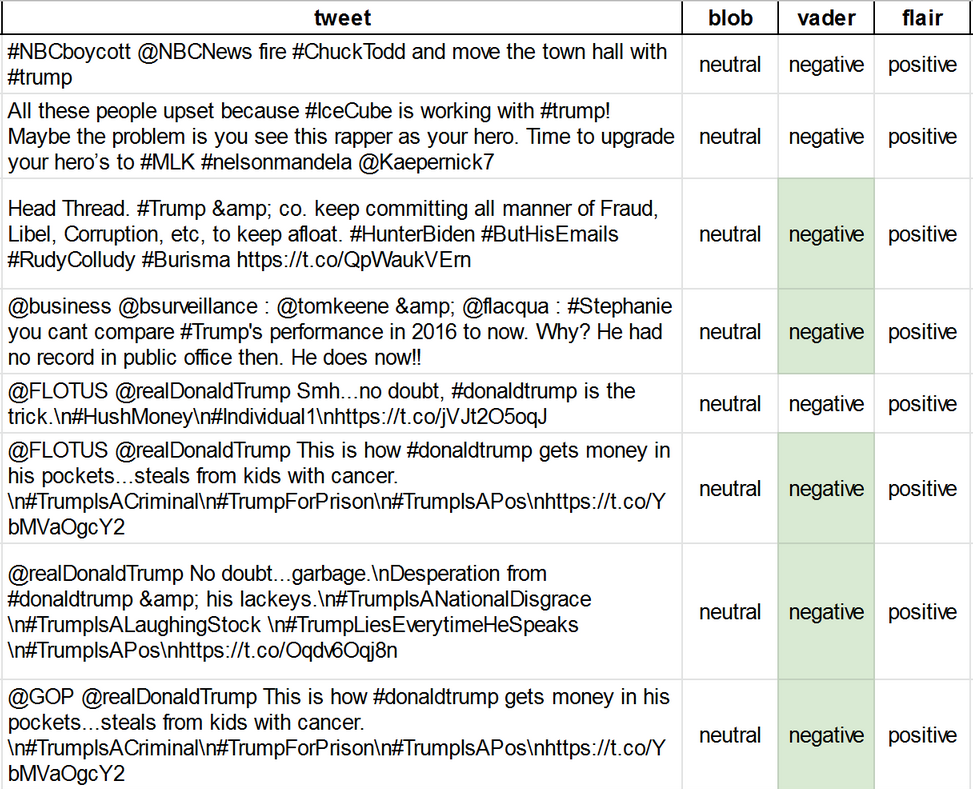

Based on the distribution plots and after inspecting a few tweets where all three algorithms applied different labels, I decided to use in further analyses the results from **VADER**


## 8. Actionable insights from sentiment analysis of tweets

There are several ways to use sentiment analysis on tweets related to a political campaign.  

One is to try to predict the election results from the sentiments towards the candidated. 

Another one, which I will focus on, is to gauge how the voters feel towards the candidates while the campaign is still ongoing. I will focus on this one. Our question is: in which states is candidate Biden running behind Trump (according to the average sentiment expressed by tweets from those states) ?  

We begi by computing mean polarity per candidate per state.

In [ ]:
rel_senti = tweets_df[['state','vader_clean_polarity','ds']].groupby(['state','ds']).mean()
rel_senti.reset_index(inplace = True)

In [ ]:
rel_senti.head(6)

Are we missing any data points ?

In [ ]:
rel_senti.shape

For each state we should have two entries: one for the average sentiment towards Biden and one for Trump. The code cell above indicates one datapoint is missing (because we have the odd number of entries 103 instead of 104).  
What info is missing ?

In [ ]:
tmp = (rel_senti.state.value_counts()!=2).reset_index()
tmp[tmp.state == True]

For which candidate are we missing tweets in South Dakota ?

In [ ]:
rel_senti[rel_senti.state=='South Dakota']

We have no tweets (in English) about Trump from South Dakota. So we will assign an average sentiment of 0, which makes sense because 0 is neutral.

In [ ]:
rel_senti = rel_senti.append({'state': 'South Dakota', 'ds':'trump', 'vader_clean_polarity':0}, ignore_index=True)
rel_senti.sort_values('state', ascending=True, inplace=True)
rel_senti.reset_index(drop=True)

In [ ]:
rel_senti = rel_senti[['state','vader_clean_polarity']].groupby('state')
rel_senti = rel_senti.diff(periods=-1)

#uncomment to see what we've done so far
#rel_senti

In [ ]:
rel_senti.dropna(inplace=True)
rel_senti.reset_index(inplace = True, drop=True)
rel_senti.head(4)

In [ ]:
states_df = pd.DataFrame(data=np.sort(tweets_df.state.unique()), columns=['state'])
rel_senti = rel_senti.join(states_df)
rel_senti.head(3)

For better visualizing these results, I will use [Kepler](http://kepler.gl/) to display them overlaid on a map showing USA states. 

For this purpose, I will also need a geoJSON file which I obtained from <a href='https://eric.clst.org/tech/usgeojson/'>this link</a>

If you're not familiar with GeoJSON, I found <a href="https://developer.here.com/blog/an-introduction-to-geojson">this</a> to be a good introduction.

We are interested in the public opinion of users that are tweeting about the election from the USA.

### Visualizations

To better visualize our data we will use the geographic map of the United States in our visualizations. More specifically we will use a geojson file of the US states that we can then process with [Kepler](http://kepler.gl/). The .json file that we are using can be retrieved [here](https://eric.clst.org/tech/usgeojson/). 

Fist we load the json file into a DataFrame.

In [ ]:
geo_usa_df = pd.read_json('../input/a-simple-geojson-file-for-us-state/geo_usa.json')
geo_usa_df.head()

In [ ]:
GEO_ID = []
STATE = []
NAME = []
CENSUSAREA = []
geometry = []

for row in geo_usa_df.features.iteritems():
    GEO_ID.append(row[1]["properties"]["GEO_ID"])
    STATE.append(row[1]["properties"]["STATE"])
    NAME.append(row[1]["properties"]["NAME"])
    CENSUSAREA.append(row[1]["properties"]["CENSUSAREA"])
    geometry.append(row[1]["geometry"])

In [ ]:
geo_usa_df.head(1)

In [ ]:
geo_usa_df['GEO_ID'] = GEO_ID
geo_usa_df['STATE'] = STATE
geo_usa_df['NAME'] = NAME
geo_usa_df['CENSUSAREA'] = CENSUSAREA
geo_usa_df['geometry'] = geometry

In [ ]:
#Rename NAME feature to State
geo_usa_df = geo_usa_df.rename(columns={'NAME': 'state'})

In [ ]:
row = rel_senti[rel_senti.state=='Maine']
biden_score = row.vader_clean_polarity

Assign one candidate to each state depending who is more 'liked'.

In [ ]:
def assign_candidate(x):
    row = rel_senti[rel_senti.state==x]
    biden_score = row.vader_clean_polarity
    
    if biden_score.iloc[0]>0:
        return 'biden'
    else:
        return 'trump'

geo_usa_df['winner'] = geo_usa_df['state'].apply(lambda x: assign_candidate(x))

In [ ]:
def assign_biden_score(x):
    row = rel_senti[rel_senti.state==x]
    biden_score = row.vader_clean_polarity
    return biden_score.iloc[0]
    
geo_usa_df['biden_score'] = geo_usa_df['state'].apply(lambda x: assign_biden_score(x))

Let's just make sure the json we used has the exact same name for states as our DataFrame. Just to prevent silly errors further down the road.

In [ ]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
 
# Driver Code
li1 = NAME
li2 = list(tweets_df.state.unique())

print(Diff(li1, li2)) #an empty output means the two lists of states are identical

Let's display the states capitals too, just to make our plot prettier.  
us-state-capitals.csv contains the latitude and longitude for all state capitals. 

In [ ]:
# Read in the lat and long of states captials 
geo_us_capitals_df = pd.read_csv('../input/usa-state-capitals-lat-long/usa-state-capitals.csv')

#Rename 'origin' feature to state
#geo_us_capitals_df = geo_us_capitals_df.rename(columns={'origin': 'state'})
geo_us_capitals_df.head()

In [ ]:
geo_usa_df = pd.merge(geo_usa_df, geo_us_capitals_df, on='state', how='left')

In [ ]:
geo_usa_df.to_json(out_folder+'/geo_usa_senti.json',orient='records')

The geo_usa_senti.json file created by running the code cell above is the one I imported in <a href='https://kepler.gl/'>Kepler</a> to produce the following two visualizations.  

If you want to try out Kepler yourself and produce your own geospatial visualization, <a href='https://www.youtube.com/watch?v=BEZjt08Myxs&ab_channel=LeighHalliday'>this turorial</a> is a good place to get your started.

### States by most liked candidate  

I mentioned earlier I was going to use <a href='https://kepler.gl/'>Kepler</a> for displaying insight from the sentiment analysis of tweets. You can see that this form of visualization is much more powerful than showing the same data as a table of numbers or even various types plots.  

For an introduction to using Kepler for obtaining such an image, check out <a href="https://www.youtube.com/watch?v=BEZjt08Myxs">this video tutorial</a>.

![States by most liked candidate](https://mihaelagrigore.info/wp-content/uploads/2021/03/winners.jpg)

Visualization of most liked candidate per state, as assessed by the relative average sentiment score. 

I got the idea of showing geospatial data using Kepler from my colleague, <a href='https://www.linkedin.com/in/lara-wagner-8446789a/'>Lara Wagner</a>

### States by sentiment intensity towards Biden

We know from the image above which are the states where people are more positive towards Trump than towards Biden. But we also want to know by how much. This will help our campaign strategy because we can direct our efforts where they are most needed or even where we can obtain the highest effect for the lowest 'effort'.  

The legend on the right is the default one from Kepler. If it's too small to read, mind that the whiter the shade, the more people in that state prefer Trump.  

![Relative sentiment towards Biden](https://mihaelagrigore.info/wp-content/uploads/2021/03/relative_senti.jpg)

Now we know where we need to intervene to win people over without running expensive polls where hundreds or thousands of people get called and surveyed.  

We can pair this analysis with a topic modelling analysis of the same tweets to see which topic are hot in the respective states, so that we know what to discuss about for the highest effect in each of these states. I will dedicate a separate Notebook to topic modelling using Latent Dirichlet allocation.